In [1]:
import torch
from emonet import EmoNet
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
random.seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmoNet(n_expression=8)
model.load_state_dict(torch.load("D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\cfd_finetuned_emonet_100_epochs.pth"))
model.to(device)
model.eval()

### Preparing data for Neutral Male (B and W)

In [3]:
#defining image transform
cfd_transform=transforms.Compose([ transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [4]:
#loading images from folders
def load_images(path):
    images_list=[]
    filenames=os.listdir(path)
    for file in filenames:
        img_path=os.path.join(path,file)
        image = Image.open(img_path).convert("RGB")
        image = cfd_transform(image)
        images_list.append(image)
    return torch.stack(images_list)

In [5]:
path1="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\Black\\Neutral"
path2="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\White\\Neutral"  #change accordingly

b_imglist=load_images(path1)
w_imglist=load_images(path2)

print("Black Neutral Images Shape:", b_imglist.shape)
print("White Neutral Images Shape:", w_imglist.shape)

#we've loaded corresponding images

Black Neutral Images Shape: torch.Size([93, 3, 256, 256])
White Neutral Images Shape: torch.Size([93, 3, 256, 256])


### Analyzing for conv4, last conv layer before hourglass block

In [6]:
#observing last conv_layer before hourglass block, conv_4
black_feature_maps_dict = {}
def hook_fn(module, input, output):
    black_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [7]:
#observing last conv_layer before hourglass block, conv_4
white_feature_maps_dict = {}
def hook_fn(module, input, output):
    white_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [8]:
#passing angry black male images through emonet
black_feature_maps=[]
white_feature_maps=[]

with torch.no_grad():
    for i in range(b_imglist.shape[0]):
        image = b_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        black_feature_maps.append(black_feature_maps_dict["conv4"])

In [9]:
with torch.no_grad():
    for i in range(w_imglist.shape[0]):
        image = w_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        white_feature_maps.append(white_feature_maps_dict["conv4"]) 

In [10]:
wfm_tensor=torch.stack(white_feature_maps)
bfm_tensor=torch.stack(black_feature_maps)

In [11]:
wfm_tensor.shape

torch.Size([93, 1, 256, 64, 64])

In [12]:
black_mean_activation = bfm_tensor.mean(dim=0) 
white_mean_activation = wfm_tensor.mean(dim=0) 

activation_difference = black_mean_activation - white_mean_activation

#averaging activations of feature maps for all images of black and white, and taking their absolute difference.

print("Black Mean Activation Shape:", black_mean_activation.shape)
print("White Mean Activation Shape:", white_mean_activation.shape)
print("Activation Difference Shape:", activation_difference.shape)

Black Mean Activation Shape: torch.Size([1, 256, 64, 64])
White Mean Activation Shape: torch.Size([1, 256, 64, 64])
Activation Difference Shape: torch.Size([1, 256, 64, 64])


In [13]:
black_mean_activation = black_mean_activation.squeeze(0).cpu().detach().numpy()  
white_mean_activation = white_mean_activation.squeeze(0).cpu().detach().numpy()  
activation_difference = activation_difference.squeeze(0).cpu().detach().numpy()  

In [14]:
def get_conv4_activations(image_tensor, model, suppressed_indices=None):
    activations = {}

    def conv4_hook(module, input, output):
        if suppressed_indices is not None:
            output = output.clone()
            output[:, suppressed_indices, :, :] = 0
        activations["conv4"] = output

    handle = model.conv4.register_forward_hook(conv4_hook)

    with torch.no_grad():
        _ = model(image_tensor.to(next(model.parameters()).device))

    handle.remove()
    return activations["conv4"].squeeze(0).cpu() 

def visualize_activation_difference(image_tensor, model, suppressed_indices, title="Activation Diff (Pre - Post)", figsize=(6, 6)):
    A_pre = get_conv4_activations(image_tensor, model)
    A_post = get_conv4_activations(image_tensor, model, suppressed_indices=suppressed_indices)
    A_diff = A_pre - A_post 

    diff_map = A_diff.sum(dim=0)
    diff_map = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-5)

    resized_diff = F.interpolate(
        diff_map.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False
    ).squeeze()

    orig = image_tensor.squeeze(0).permute(1, 2, 0).cpu()
    orig = (orig * 0.5 + 0.5).clamp(0, 1).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(orig)
    plt.imshow(resized_diff, cmap='bwr', alpha=0.5)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [15]:
suppressed_indices = [123,185,88]

In [16]:
def visualize_pre_post_diff(image_tensor, model, suppressed_indices, figsize=(18, 6)):
    A_pre = get_conv4_activations(image_tensor, model)
    A_post = get_conv4_activations(image_tensor, model, suppressed_indices=suppressed_indices)
    A_diff = A_pre - A_post  # [C, H, W]

    pre_map = A_pre.sum(dim=0)
    post_map = A_post.sum(dim=0)
    diff_map = A_diff.sum(dim=0)
    pre_map_norm = (pre_map - pre_map.min()) / (pre_map.max() - pre_map.min() + 1e-5)
    post_map_norm = (post_map - post_map.min()) / (post_map.max() - post_map.min() + 1e-5)

    max_abs = diff_map.abs().max() + 1e-5
    diff_map_norm = diff_map / max_abs  #  range [-1, 1]

    
    pre_map_resized = F.interpolate(pre_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    post_map_resized = F.interpolate(post_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    diff_map_resized = F.interpolate(diff_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    orig = image_tensor.squeeze(0).permute(1, 2, 0).cpu()  # [H, W, 3]
    orig = (orig * 0.5 + 0.5).clamp(0, 1).numpy()

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    axs[0].imshow(orig)
    axs[0].imshow(pre_map_resized, cmap='jet', alpha=0.5)
    axs[0].set_title(f"Pre-Suppression")
    axs[0].axis("off")
    axs[1].imshow(orig)
    axs[1].imshow(post_map_resized, cmap='jet', alpha=0.5)
    axs[1].set_title(f"Post-Suppression")
    axs[1].axis("off")
    im = axs[2].imshow(orig)
    im = axs[2].imshow(diff_map_resized, cmap='bwr', alpha=0.5)
    axs[2].set_title(f"(Pre - Post)")
    axs[2].axis("off")


    plt.tight_layout()
    plt.show()

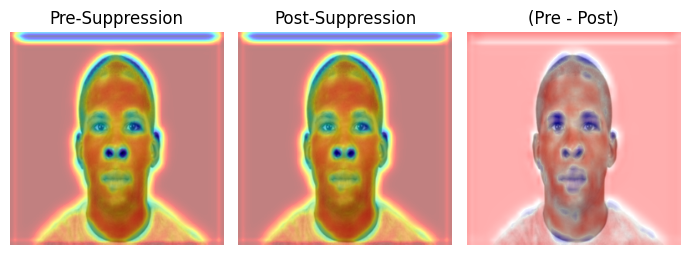

In [17]:
visualize_pre_post_diff(
    image_tensor=b_imglist[0].unsqueeze(0),
    model=model,
    suppressed_indices=suppressed_indices,
    figsize=(7, 6)
)

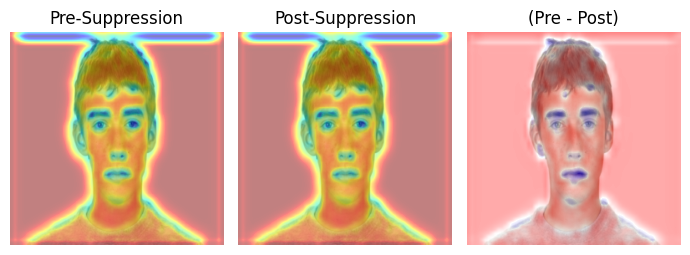

In [18]:
visualize_pre_post_diff(
    image_tensor=w_imglist[0].unsqueeze(0),
    model=model,
    suppressed_indices=suppressed_indices,
    figsize=(7, 6)
)